XGBoost model loaded successfully from xgb_model.json
Found 455 rows for product: WeTV VIP


d:\Skripsi\Model Steps\Preprocessing\Step 1\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                  │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 12,101 (47.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0264 - mae: 0.0730 - rmse: 0.1421 - val_loss: 0.1838 - val_mae: 0.3675 - val_rmse: 0.4224 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164 - mae: 0.0505 - rmse: 0.1046 - val_loss: 0.1402 - val_mae: 0.3084 - val_rmse: 0.3682 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0173 - mae: 0.0661 - rmse: 0.1121 - val_loss: 0.1205 - val_mae: 0.2811 - val_rmse: 0.3413 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125 - mae: 0.0545 - rmse: 0.0924 - val_loss: 0.1084 - val_mae: 0.2643 - val_rmse: 0.3238 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0122 - mae: 0.0532 - rmse: 0.0925 - val_loss: 0.0975 - val_mae: 0.2485 - val_rmse: 0.3072 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100 - mae: 0.0440 - rmse: 0.0829 - val_loss: 0.0861 - val

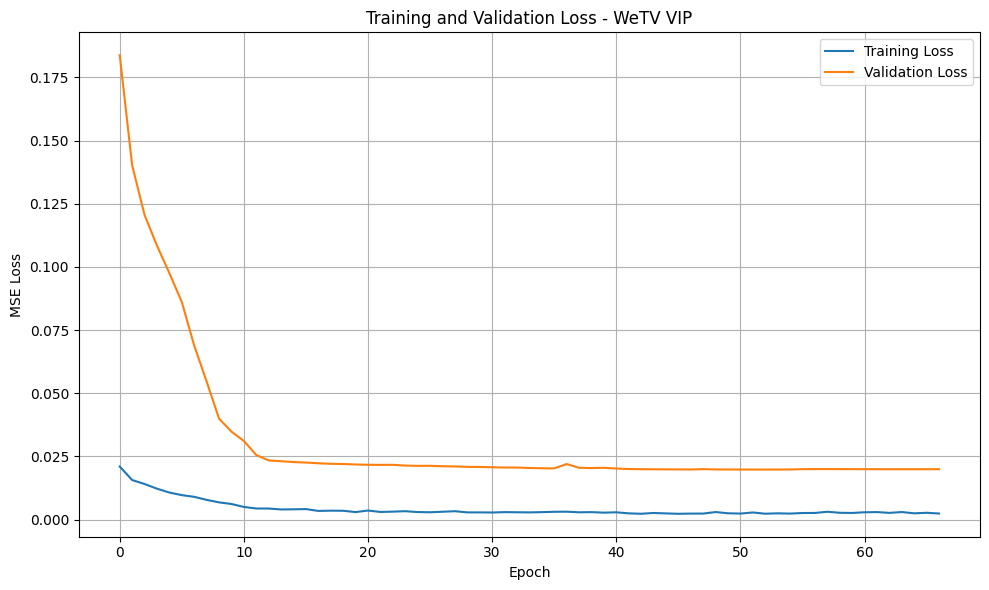


Starting Forecasting and Classification Process
Day  1/30 | Forecasted Revenue: 3452055.59 -> XGBoost Class: Good for Sale
Day  2/30 | Forecasted Revenue: 3569203.15 -> XGBoost Class: Good for Sale
Day  3/30 | Forecasted Revenue: 3636315.86 -> XGBoost Class: Good for Sale
Day  4/30 | Forecasted Revenue: 3685747.85 -> XGBoost Class: Good for Sale
Day  5/30 | Forecasted Revenue: 3719943.46 -> XGBoost Class: Good for Sale
Day  6/30 | Forecasted Revenue: 3745746.65 -> XGBoost Class: Good for Sale
Day  7/30 | Forecasted Revenue: 3765902.21 -> XGBoost Class: Good for Sale
Day  8/30 | Forecasted Revenue: 3782601.75 -> XGBoost Class: Good for Sale
Day  9/30 | Forecasted Revenue: 3797088.95 -> XGBoost Class: Good for Sale
Day 10/30 | Forecasted Revenue: 3810188.12 -> XGBoost Class: Good for Sale
Day 11/30 | Forecasted Revenue: 3822405.08 -> XGBoost Class: Good for Sale
Day 12/30 | Forecasted Revenue: 3834064.16 -> XGBoost Class: Good for Sale
Day 13/30 | Forecasted Revenue: 3845366.46 -> XGBoo

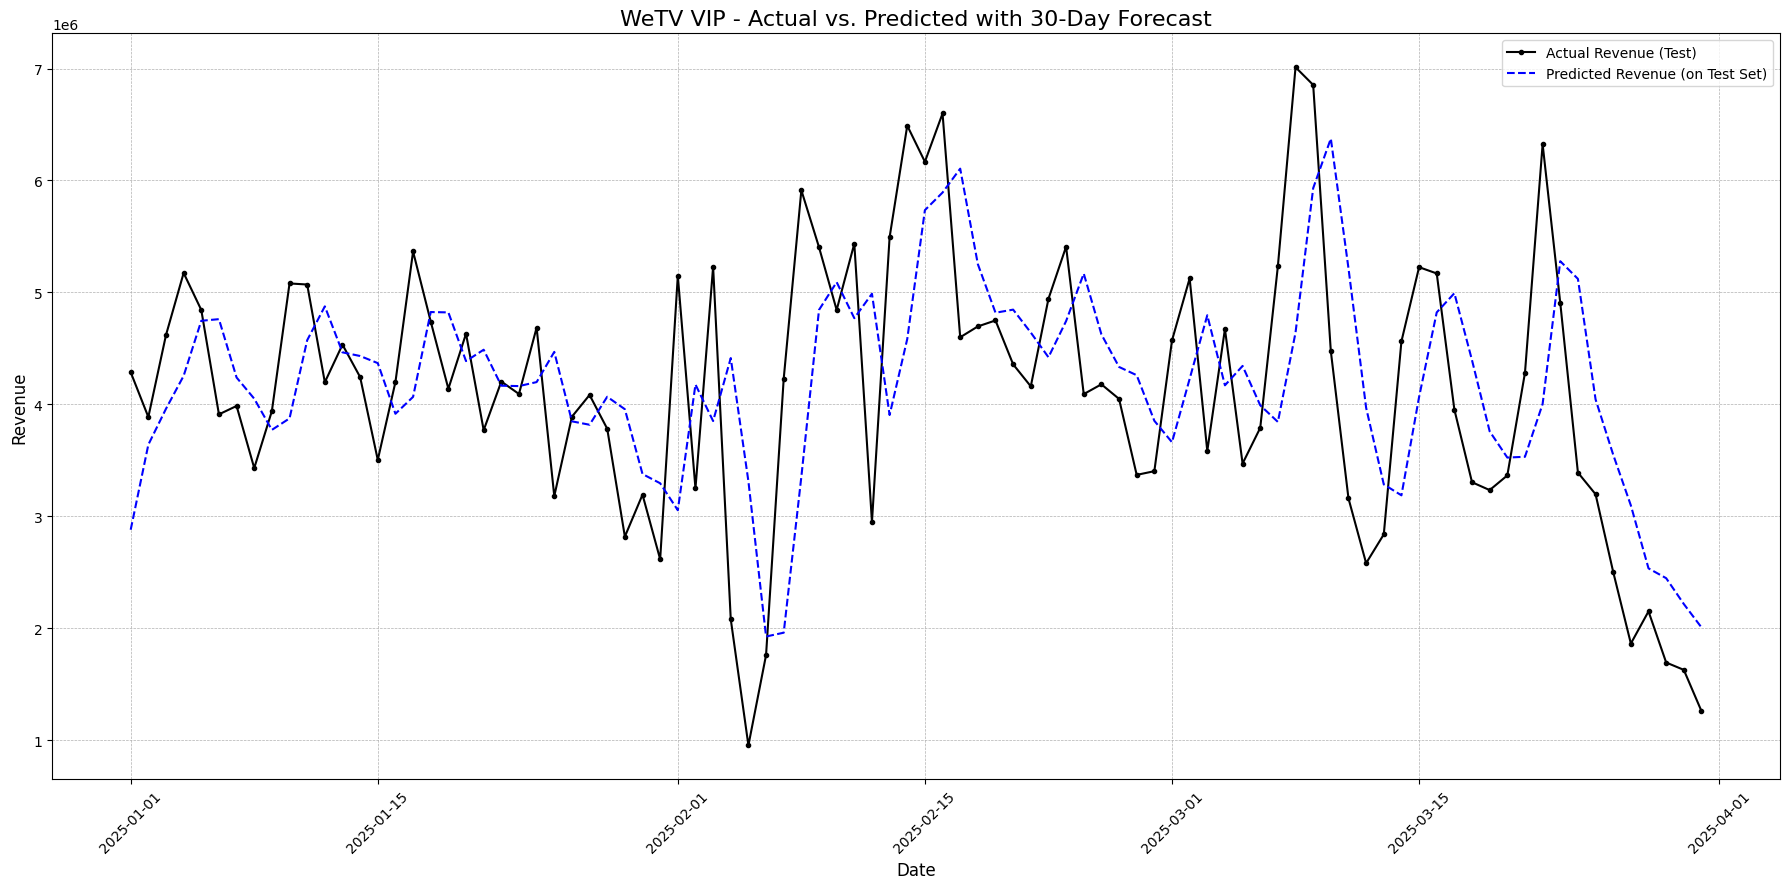


LSTM Model saved to ./model/lstm_model_WeTV VIP.h5
Script finished.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import xgboost as xgb
import os

# --- Utility Functions ---
def calculate_rmspe(y_true, y_pred):
    """
    Calculates the Root Mean Squared Percentage Error between true and predicted values.
    """
    non_zero_mask = y_true != 0
    y_true_safe = y_true[non_zero_mask]
    y_pred_safe = y_pred[non_zero_mask]

    if len(y_true_safe) == 0:
        print("Warning: Cannot calculate RMSPE because all true values are zero.")
        return np.nan

    percentage_error = (y_true_safe - y_pred_safe) / y_true_safe
    rmspe = np.sqrt(np.mean(np.square(percentage_error))) * 100
    return rmspe

# --- Configuration ---
product_name = 'WeTV VIP'
SEQ_LEN = 1
EPOCHS = 100 
BATCH_SIZE = 32
FUTURE_DAYS = 30
VAL_SPLIT = 0.2
train_test_split_ratio = 0.8
XGB_MODEL_PATH = 'xgb_model.json'

# Feature columns for the LSTM model
lstm_features = [
    'total_revenue',
    'total_revenue_ema_10',
    'total_revenue_lag_1'
]

# Define the exact feature names the XGBoost model was trained on.
xgb_features = ['total_revenue']

# NEW: Mapping for classification results
class_mapping = {
    0: 'Bad for Sale',
    1: 'Good for Sale',
    2: 'Normal Sale'
}

# --- Create Directories ---
os.makedirs('./loss-plot', exist_ok=True)
os.makedirs('./test-plot', exist_ok=True)
os.makedirs('./test-result', exist_ok=True)
os.makedirs('./model', exist_ok=True)
os.makedirs('./forecast-result', exist_ok=True)

# --- Data Loading and Preparation ---
try:
    full_df = pd.read_csv('final_dataset.csv', parse_dates=['Tanggal'])
except FileNotFoundError:
    print("Error: 'final_dataset.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- Load XGBoost Model ---
try:
    xgb_classifier = xgb.Booster()
    xgb_classifier.load_model(XGB_MODEL_PATH)
    print(f"XGBoost model loaded successfully from {XGB_MODEL_PATH}")
except xgb.core.XGBoostError as e:
    print(f"Error: Could not load XGBoost model from '{XGB_MODEL_PATH}'. Details: {e}")
    exit()

# --- Feature Engineering ---
product_df_base = full_df[full_df['Produk'] == product_name].copy()
print(f"Found {len(product_df_base)} rows for product: {product_name}")

if product_df_base.empty:
    print(f"No data found for product: {product_name} in 'final_dataset.csv'.")
    exit()

product_df_base = product_df_base.sort_values('Tanggal').reset_index(drop=True)

if 'total_revenue' not in product_df_base.columns:
    print("Error: 'total_revenue' column is missing.")
    exit()

# Create features for the LSTM model
product_df_base['total_revenue_ema_10'] = product_df_base['total_revenue'].ewm(span=10, adjust=False).mean()
product_df_base['total_revenue_lag_1'] = product_df_base['total_revenue'].shift(1)
product_df_cleaned = product_df_base.dropna(subset=lstm_features).reset_index(drop=True)

if product_df_cleaned.empty:
    print(f"Error: No data remains for {product_name} after dropping NaNs.")
    exit()

# --- Train/Test Split ---
split_index = int(len(product_df_cleaned) * train_test_split_ratio)
train_df = product_df_cleaned.iloc[:split_index].copy()
test_df = product_df_cleaned.iloc[split_index:].copy()

if train_df.empty:
    print(f"Error: Training set is empty for product: {product_name}.")
    exit()

# --- Data Scaling and Sequencing for LSTM ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[lstm_features])
test_scaled = scaler.transform(test_df[lstm_features])

def create_sequences(data, seq_len=SEQ_LEN):
    x, y = [], []
    if len(data) <= seq_len:
        print(f"Warning: Data length ({len(data)}) is not sufficient for sequence length ({seq_len}).")
        return np.array(x), np.array(y)
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i])
        y.append(data[i][0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_scaled)
x_test, y_test = create_sequences(test_scaled)

if x_train.shape[0] == 0:
    print(f"Error: Not enough data to create training sequences for {product_name} with SEQ_LEN={SEQ_LEN}.")
    exit()

# --- LSTM Model Building and Training ---
model = Sequential([
    LSTM(units=50, activation='tanh', input_shape=(SEQ_LEN, len(lstm_features)), kernel_regularizer=l2(0.001), return_sequences=False),
    Dropout(0.3),
    Dense(units=25, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', RootMeanSquaredError(name='rmse')])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT, callbacks=[early_stopping, reduce_lr], verbose=1)

# --- Plotting and Saving ---
filename_base = product_name.replace(" ", "_").replace("/", "_")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f"Training and Validation Loss - {product_name}")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'./loss-plot/{filename_base}_loss_plot.png')
plt.show()

# --- Forecasting Logic with Integrated XGBoost Classification ---
print("\n" + "="*50)
print("Starting Forecasting and Classification Process")
print("="*50)

current_sequence_scaled = train_scaled[-SEQ_LEN:].copy()
history_df_unscaled = train_df.copy()
lstm_forecasts = []
xgboost_classifications = []

for day_step in range(FUTURE_DAYS):
    input_for_lstm = current_sequence_scaled.reshape(1, SEQ_LEN, len(lstm_features))
    pred_scaled_revenue = model.predict(input_for_lstm, verbose=0)[0, 0]
    
    dummy_scaled_row = np.zeros((1, len(lstm_features)))
    dummy_scaled_row[0, 0] = pred_scaled_revenue
    pred_unscaled_revenue = scaler.inverse_transform(dummy_scaled_row)[0, 0]
    lstm_forecasts.append(pred_unscaled_revenue)
    
    last_tanggal = history_df_unscaled['Tanggal'].iloc[-1]
    next_tanggal = last_tanggal + pd.Timedelta(days=1)
    new_row_dict = {'Tanggal': next_tanggal, 'Produk': product_name, 'total_revenue': pred_unscaled_revenue}
    history_df_unscaled = pd.concat([history_df_unscaled, pd.DataFrame([new_row_dict])], ignore_index=True)
    
    temp_df_for_features = history_df_unscaled.copy()
    temp_df_for_features['total_revenue_ema_10'] = temp_df_for_features['total_revenue'].ewm(span=10, adjust=False).mean()
    temp_df_for_features['total_revenue_lag_1'] = temp_df_for_features['total_revenue'].shift(1)
    
    xgb_features_for_prediction = temp_df_for_features[xgb_features].iloc[-1:].copy()
    
    dmatrix_for_xgb = xgb.DMatrix(xgb_features_for_prediction)
    xgb_prediction_proba = xgb_classifier.predict(dmatrix_for_xgb)
    xgb_predicted_class_int = int(round(xgb_prediction_proba[0]))
    
    # Map the integer class to its string representation
    xgb_predicted_class_str = class_mapping.get(xgb_predicted_class_int, 'Unknown')
    xgboost_classifications.append(xgb_predicted_class_str)

    print(f"Day {day_step+1:>2}/{FUTURE_DAYS} | Forecasted Revenue: {pred_unscaled_revenue:10.2f} -> XGBoost Class: {xgb_predicted_class_str}")
    
    next_full_unscaled_feature_row = temp_df_for_features[lstm_features].iloc[-1:]
    next_full_scaled_feature_row = scaler.transform(next_full_unscaled_feature_row)
    current_sequence_scaled = np.vstack((current_sequence_scaled[1:], next_full_scaled_feature_row))

forecast_dates = pd.date_range(start=history_df_unscaled['Tanggal'].iloc[-FUTURE_DAYS], periods=FUTURE_DAYS)
forecast_results_df = pd.DataFrame({
    'Tanggal': forecast_dates,
    'Produk': product_name,
    'lstm_forecasted_revenue': lstm_forecasts,
    'xgboost_predicted_class': xgboost_classifications
})

forecast_filename = f'./forecast-result/{filename_base}_forecast_and_classification.csv'
forecast_results_df.to_csv(forecast_filename, index=False)
print("="*50)
print(f"Combined forecast and classification results saved to: {forecast_filename}")
print("="*50)

# --- Model Evaluation on Test Set ---
if x_test.shape[0] > 0 and len(y_test) > 0:
    true_y_test_scaled = y_test.reshape(-1, 1)
    padding_test = np.zeros((len(true_y_test_scaled), len(lstm_features) - 1))
    true_y_inverse = scaler.inverse_transform(np.hstack((true_y_test_scaled, padding_test)))[:, 0]

    pred_test_scaled = model.predict(x_test, verbose=0)
    pred_test_rescaled = scaler.inverse_transform(np.hstack((pred_test_scaled, np.zeros((len(pred_test_scaled), len(lstm_features) - 1)))))[:, 0]
    
    rmspe_value = calculate_rmspe(true_y_inverse, pred_test_rescaled)
    print("\n" + "="*47)
    print("        Model Evaluation Results (Test Set)")
    print("-"*47)
    print(f"Product: {product_name}")
    print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe_value:.2f}%")
    
    # --- NEW: Classify test set predictions with XGBoost ---
    print("\nClassifying test set predictions with XGBoost...")
    test_predictions_df = pd.DataFrame(pred_test_rescaled, columns=['total_revenue'])
    dmatrix_for_test_preds = xgb.DMatrix(test_predictions_df[xgb_features])
    test_xgb_preds_proba = xgb_classifier.predict(dmatrix_for_test_preds)
    test_xgb_preds_int = np.round(test_xgb_preds_proba).astype(int)
    test_xgb_preds_str = [class_mapping.get(p, 'Unknown') for p in test_xgb_preds_int]
    print("Classification of test set complete.")
    print("="*47)
    
    actual_test_dates = test_df['Tanggal'].iloc[SEQ_LEN : SEQ_LEN + len(true_y_inverse)]

    if not actual_test_dates.empty:
        results_df = test_df.loc[actual_test_dates.index].copy()
        results_df['predicted_revenue'] = pred_test_rescaled
        
        # Add the string classification to the results dataframe
        results_df['xgboost_predicted_class'] = test_xgb_preds_str
        
        results_df.rename(columns={'total_revenue': 'actual_revenue'}, inplace=True)
        results_filename = f'./test-result/{filename_base}_predictions_vs_actuals.csv'
        results_df.to_csv(results_filename, index=False)
        print(f"\nTest results with classification saved to: {results_filename}")

    if not actual_test_dates.empty:
        plt.figure(figsize=(18, 9))
        plt.plot(actual_test_dates, true_y_inverse, label='Actual Revenue (Test)', color='black', marker='.', linestyle='-')
        plt.plot(actual_test_dates, pred_test_rescaled, label='Predicted Revenue (on Test Set)', color='blue', linestyle='--')
        # plt.plot(forecast_results_df['Tanggal'], forecast_results_df['lstm_forecasted_revenue'], label=f'Forecast (Next {FUTURE_DAYS} Days)', color='orange', linestyle='--')
        
        plt.title(f'{product_name} - Actual vs. Predicted with {FUTURE_DAYS}-Day Forecast', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Revenue', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'./test-plot/{filename_base}_test_and_forecast_plot.png')
        plt.show()
else:
    print("x_test is empty. Cannot evaluate on test data. Plotting forecast only.")
    # Plotting forecast-only logic remains the same

# --- Final Steps ---
model.save(f'./model/lstm_model_{product_name}.h5')
print(f"\nLSTM Model saved to ./model/lstm_model_{product_name}.h5")
print("Script finished.")
